# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 3796, 0.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [13]:
#Taxa de aprendizagem, e usada a mesma em todo o codigo
learnRate = 0.001
graficoName = "SMOTE-0.001-"

In [16]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [15]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.5107 - acc: 0.4831 - val_loss: 0.4959 - val_acc: 0.4892
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.4982 - acc: 0.4950 - val_loss: 0.4944 - val_acc: 0.4924
Epoch 3/2000
7592/7592 [==============================] - ETA: 0s - loss: 0.4983 - acc: 0.494 - 0s - loss: 0.4962 - acc: 0.4957 - val_loss: 0.4920 - val_acc: 0.4926
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.3866 - acc: 0.5744 - val_loss: 0.1941 - val_acc: 0.7308
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1379 - acc: 0.8097 - val_loss: 0.1287 - val_acc: 0.8317
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1092 - acc: 0.8597 - val_loss: 0.1091 - val_acc: 0.8725
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0975 - acc: 0.8801 - val_loss: 0.1004 - val_acc: 0.8754
Epoch 8/2000
7592/7592 [=

7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9189 - val_loss: 0.0789 - val_acc: 0.8962
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9183 - val_loss: 0.0809 - val_acc: 0.8941
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9197 - val_loss: 0.0798 - val_acc: 0.8957
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9190 - val_loss: 0.0820 - val_acc: 0.8930
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9191 - val_loss: 0.0794 - val_acc: 0.8962
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9193 - val_loss: 0.0789 - val_acc: 0.8949
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9203 - val_loss: 0.0798 - val_acc: 0.8952
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9195 - val_loss: 0.0806 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9202 - val_loss: 0.0798 - val_acc: 0.8933
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0803 - val_acc: 0.8928
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9200 - val_loss: 0.0805 - val_acc: 0.8933
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9199 - val_loss: 0.0809 - val_acc: 0.8925
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9202 - val_loss: 0.0800 - val_acc: 0.8923
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9203 - val_loss: 0.0799 - val_acc: 0.8925
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9200 - val_loss: 0.0802 - val_acc: 0.8936
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9207 - val_loss: 0.0797 -

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9194 - val_loss: 0.0812 - val_acc: 0.8925
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9202 - val_loss: 0.0806 - val_acc: 0.8930
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9195 - val_loss: 0.0816 - val_acc: 0.8909
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0803 - val_acc: 0.8917
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9204 - val_loss: 0.0812 - val_acc: 0.8917
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0800 - val_acc: 0.8920
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0807 - val_acc: 0.8923
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0803 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0816 - val_acc: 0.8928
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0808 - val_acc: 0.8915
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0808 - val_acc: 0.8923
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9207 - val_loss: 0.0815 - val_acc: 0.8925
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0820 - val_acc: 0.8912
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0809 - val_acc: 0.8925
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0814 - val_acc: 0.8925
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0807 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0814 - val_acc: 0.8904
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0817 - val_acc: 0.8896
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0809 - val_acc: 0.8909
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9200 - val_loss: 0.0814 - val_acc: 0.8923
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0820 - val_acc: 0.8909
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0814 - val_acc: 0.8909
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0810 - val_acc: 0.8915
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0809 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0809 - val_acc: 0.8928
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0816 - val_acc: 0.8904
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9190 - val_loss: 0.0809 - val_acc: 0.8925
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0823 - val_acc: 0.8907
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9200 - val_loss: 0.0824 - val_acc: 0.8896
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9204 - val_loss: 0.0821 - val_acc: 0.8928
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0810 - val_acc: 0.8909
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9190 - val_loss: 0.0811 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0815 - val_acc: 0.8894
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0813 - val_acc: 0.8901
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9193 - val_loss: 0.0823 - val_acc: 0.8909
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0822 - val_acc: 0.8894
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0815 - val_acc: 0.8894
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9200 - val_loss: 0.0819 - val_acc: 0.8904
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0817 - val_acc: 0.8907
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0822 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0816 - val_acc: 0.8901
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0816 - val_acc: 0.8907
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9210 - val_loss: 0.0813 - val_acc: 0.8899
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0817 - val_acc: 0.8899
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9207 - val_loss: 0.0813 - val_acc: 0.8915
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0822 - val_acc: 0.8909
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0813 - val_acc: 0.8894
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9197 - val_loss: 0.0818 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0813 - val_acc: 0.8899
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0818 - val_acc: 0.8891
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0820 - val_acc: 0.8880
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0824 - val_acc: 0.8899
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0812 - val_acc: 0.8904
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0821 - val_acc: 0.8888
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0811 - val_acc: 0.8896
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0825 -

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9190 - val_loss: 0.0826 - val_acc: 0.8899
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0816 - val_acc: 0.8899
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9206 - val_loss: 0.0820 - val_acc: 0.8894
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0810 - val_acc: 0.8891
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0815 - val_acc: 0.8880
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9195 - val_loss: 0.0811 - val_acc: 0.8915
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9190 - val_loss: 0.0809 - val_acc: 0.8923
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9199 - val_loss: 0.0811 -

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9203 - val_loss: 0.0817 - val_acc: 0.8894
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0815 - val_acc: 0.8901
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9198 - val_loss: 0.0816 - val_acc: 0.8917
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0818 - val_acc: 0.8907
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9200 - val_loss: 0.0813 - val_acc: 0.8912
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0812 - val_acc: 0.8904
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0812 - val_acc: 0.8915
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0822 -

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9199 - val_loss: 0.0815 - val_acc: 0.8899
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0812 - val_acc: 0.8901
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0819 - val_acc: 0.8896
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9204 - val_loss: 0.0811 - val_acc: 0.8915
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9200 - val_loss: 0.0808 - val_acc: 0.8915
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9202 - val_loss: 0.0812 - val_acc: 0.8894
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9200 - val_loss: 0.0820 - val_acc: 0.8896
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0822 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0826 - val_acc: 0.8891
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9211 - val_loss: 0.0808 - val_acc: 0.8899
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0809 - val_acc: 0.8896
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0820 - val_acc: 0.8909
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0826 - val_acc: 0.8883
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0819 - val_acc: 0.8899
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0808 - val_acc: 0.8907
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9197 - val_loss: 0.0809 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0811 - val_acc: 0.8925
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0811 - val_acc: 0.8899
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9202 - val_loss: 0.0816 - val_acc: 0.8894
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9206 - val_loss: 0.0809 - val_acc: 0.8923
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0822 - val_acc: 0.8896
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0816 - val_acc: 0.8901
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0818 - val_acc: 0.8904
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9207 - val_loss: 0.0819 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0835 - val_acc: 0.8870
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0830 - val_acc: 0.8888
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0808 - val_acc: 0.8915
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0814 - val_acc: 0.8899
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9206 - val_loss: 0.0817 - val_acc: 0.8896
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9195 - val_loss: 0.0817 - val_acc: 0.8899
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0810 - val_acc: 0.8909
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9203 - val_loss: 0.0810 -

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0809 - val_acc: 0.8912
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0817 - val_acc: 0.8917
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0822 - val_acc: 0.8909
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0818 - val_acc: 0.8904
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0811 - val_acc: 0.8888
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0810 - val_acc: 0.8909
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9195 - val_loss: 0.0814 - val_acc: 0.8901
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9203 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0817 - val_acc: 0.8915
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0816 - val_acc: 0.8896
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0816 - val_acc: 0.8915
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0817 - val_acc: 0.8909
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0818 - val_acc: 0.8886
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9197 - val_loss: 0.0812 - val_acc: 0.8899
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9203 - val_loss: 0.0815 - val_acc: 0.8912
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9190 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9193 - val_loss: 0.0822 - val_acc: 0.8894
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9198 - val_loss: 0.0813 - val_acc: 0.8907
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0815 - val_acc: 0.8891
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0810 - val_acc: 0.8894
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0814 - val_acc: 0.8907
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0817 - val_acc: 0.8917
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9203 - val_loss: 0.0810 - val_acc: 0.8923
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9197 - val_loss: 0.0818 - val_acc: 0.8920
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9191 - val_loss: 0.0812 - val_acc: 0.8899
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0813 - val_acc: 0.8894
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0819 - val_acc: 0.8901
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9197 - val_loss: 0.0814 - val_acc: 0.8904
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0819 - val_acc: 0.8899
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0815 - val_acc: 0.8899
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9200 - val_loss: 0.0817 - val_acc: 0.8901
Epoch 1261/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0825 - val_acc: 0.8886
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9207 - val_loss: 0.0819 - val_acc: 0.8899
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0809 - val_acc: 0.8904
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0812 - val_acc: 0.8901
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9191 - val_loss: 0.0827 - val_acc: 0.8899
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0814 - val_acc: 0.8901
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0816 - val_acc: 0.8901
Epoch 1323/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9200 - val_loss: 0.0827 - val_acc: 0.8891
Epoch 1324/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0819 - val_acc: 0.8899
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0811 - val_acc: 0.8915
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9208 - val_loss: 0.0832 - val_acc: 0.8870
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0818 - val_acc: 0.8896
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0816 - val_acc: 0.8896
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0820 - val_acc: 0.8894
Epoch 1386/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0825 - val_acc: 0.8888
Epoch 1387/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9206 - val_loss: 0.0821 - val_acc: 0.8894
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0818 - val_acc: 0.8901
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0816 - val_acc: 0.8915
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9187 - val_loss: 0.0812 - val_acc: 0.8888
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0813 - val_acc: 0.8894
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9190 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0809 - val_acc: 0.8896
Epoch 1449/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0813 - val_acc: 0.8901
Epoch 1450/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9193 - val_loss: 0.0811 - val_acc: 0.8909
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0811 - val_acc: 0.8904
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0814 - val_acc: 0.8896
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0825 - val_acc: 0.8894
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0811 - val_acc: 0.8917
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9199 - val_loss: 0.0819 - val_acc: 0.8904
Epoch 1512/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0814 - val_acc: 0.8899
Epoch 1513/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0810 - val_acc: 0.8888
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0810 - val_acc: 0.8896
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0811 - val_acc: 0.8915
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0818 - val_acc: 0.8896
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9197 - val_loss: 0.0811 - val_acc: 0.8888
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9208 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0820 - val_acc: 0.8894
Epoch 1575/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0818 - val_acc: 0.8917
Epoch 1576/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0812 - val_acc: 0.8912
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9194 - val_loss: 0.0820 - val_acc: 0.8907
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0811 - val_acc: 0.8899
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0811 - val_acc: 0.8912
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9186 - val_loss: 0.0811 - val_acc: 0.8901
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0811 - val_acc: 0.8899
Epoch 1638/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0815 - val_acc: 0.8899
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9207 - val_loss: 0.0810 - val_acc: 0.8917
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0824 - val_acc: 0.8888
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9204 - val_loss: 0.0827 - val_acc: 0.8886
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0833 - val_acc: 0.8888
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9198 - val_loss: 0.0819 - val_acc: 0.8894
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9204 - val_loss: 0.0816 - val_acc: 0.8907
Epoch 1701/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9186 - val_loss: 0.0810 - val_acc: 0.8917
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9194 - val_loss: 0.0814 - val_acc: 0.8901
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9206 - val_loss: 0.0810 - val_acc: 0.8923
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0815 - val_acc: 0.8901
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9200 - val_loss: 0.0808 - val_acc: 0.8925
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0812 - val_acc: 0.8904
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0818 - val_acc: 0.8888
Epoch 1764/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0816 - val_acc: 0.8894
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0820 - val_acc: 0.8920
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9194 - val_loss: 0.0817 - val_acc: 0.8904
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0808 - val_acc: 0.8917
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0831 - val_acc: 0.8909
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9191 - val_loss: 0.0816 - val_acc: 0.8901
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9195 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0814 - val_acc: 0.8894
Epoch 1826/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0825 - val_acc: 0.8888
Epoch 1827/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9206 - val_loss: 0.0811 - val_acc: 0.8915
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0817 - val_acc: 0.8899
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0813 - val_acc: 0.8907
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0814 - val_acc: 0.8891
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0816 - val_acc: 0.8899
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9200 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9203 - val_loss: 0.0812 - val_acc: 0.8894
Epoch 1889/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9199 - val_loss: 0.0815 - val_acc: 0.8904
Epoch 1890/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9198 - val_loss: 0.0820 - val_acc: 0.8912
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9199 - val_loss: 0.0810 - val_acc: 0.8912
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9200 - val_loss: 0.0811 - val_acc: 0.8894
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0817 - val_acc: 0.8901
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9193 - val_loss: 0.0817 - val_acc: 0.8901
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9195 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9195 - val_loss: 0.0809 - val_acc: 0.8901
Epoch 1952/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9197 - val_loss: 0.0810 - val_acc: 0.8907
Epoch 1953/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0821 - val_acc: 0.8901
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0.0815 - val_acc: 0.8907
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9195 - val_loss: 0.0832 - val_acc: 0.8878
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9202 - val_loss: 0.0814 - val_acc: 0.8915
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9200 - val_loss: 0.0810 - val_acc: 0.8888
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9204 - val_loss: 0

In [17]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1408/1962 [====================>.........] - ETA: 0s[0.055192067490076067, 0.93628950038816583]


<IPython.core.display.Javascript object>


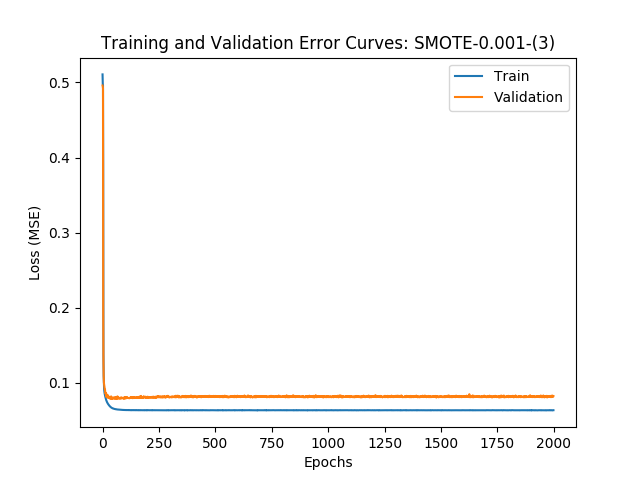

<IPython.core.display.Javascript object>


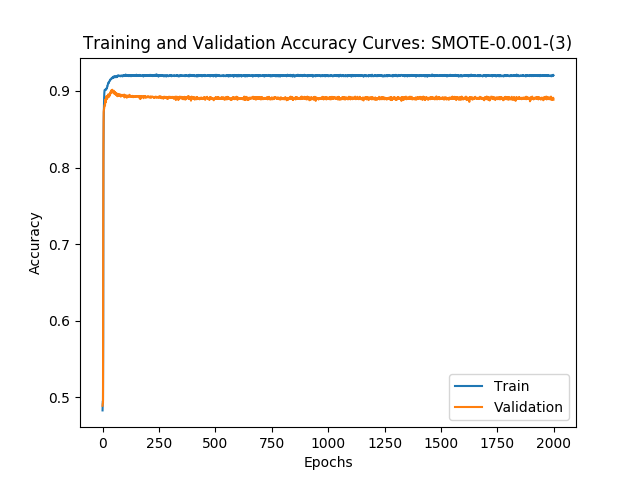

Matriz de confusão
[[1781  117]
 [   8   56]]

Train Loss:       0.0664
Validation Loss:  0.0786
Accuracy:         0.9363
MSE:              0.0637
AUROC:            0.9503


In [18]:
plot_training_error_curves(history, graficoName + "(3)")
plot_training_acc_curves(history, graficoName + "(3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [19]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.6395 - acc: 0.4442 - val_loss: 0.5332 - val_acc: 0.4742
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.5464 - acc: 0.4831 - val_loss: 0.5123 - val_acc: 0.4879
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.5229 - acc: 0.4910 - val_loss: 0.5050 - val_acc: 0.4953
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.5121 - acc: 0.4941 - val_loss: 0.5024 - val_acc: 0.4979
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.5069 - acc: 0.4958 - val_loss: 0.5012 - val_acc: 0.4984
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.5042 - acc: 0.4970 - val_loss: 0.5008 - val_acc: 0.4992
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.5025 - acc: 0.4976 - val_loss: 0.5006 - val_acc: 0.4995
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9257 - val_loss: 0.0862 - val_acc: 0.8999
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9262 - val_loss: 0.0861 - val_acc: 0.8988
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9264 - val_loss: 0.0857 - val_acc: 0.8994
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9272 - val_loss: 0.0862 - val_acc: 0.8994
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9268 - val_loss: 0.0860 - val_acc: 0.8996
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9272 - val_loss: 0.0863 - val_acc: 0.8996
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9260 - val_loss: 0.0865 - val_acc: 0.8994
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9266 - val_loss: 0.0857 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9331 - val_loss: 0.0902 - val_acc: 0.8941
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9335 - val_loss: 0.0894 - val_acc: 0.8975
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9332 - val_loss: 0.0890 - val_acc: 0.8978
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9335 - val_loss: 0.0890 - val_acc: 0.8986
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9327 - val_loss: 0.0899 - val_acc: 0.8957
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9334 - val_loss: 0.0877 - val_acc: 0.8996
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9332 - val_loss: 0.0889 - val_acc: 0.8975
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9341 - val_loss: 0.0894 -

7592/7592 [==============================] - 0s - loss: 0.0608 - acc: 0.9343 - val_loss: 0.0921 - val_acc: 0.8962
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0608 - acc: 0.9351 - val_loss: 0.0906 - val_acc: 0.8973
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9348 - val_loss: 0.0921 - val_acc: 0.8957
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9341 - val_loss: 0.0920 - val_acc: 0.8959
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9344 - val_loss: 0.0910 - val_acc: 0.8967
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9347 - val_loss: 0.0917 - val_acc: 0.8965
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9343 - val_loss: 0.0917 - val_acc: 0.8965
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9345 - val_loss: 0.0924 -

7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9345 - val_loss: 0.0927 - val_acc: 0.8949
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9347 - val_loss: 0.0912 - val_acc: 0.8970
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9345 - val_loss: 0.0922 - val_acc: 0.8959
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9343 - val_loss: 0.0916 - val_acc: 0.8967
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9348 - val_loss: 0.0931 - val_acc: 0.8959
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9344 - val_loss: 0.0918 - val_acc: 0.8967
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9341 - val_loss: 0.0920 - val_acc: 0.8962
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9351 - val_loss: 0.0920 -

7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9340 - val_loss: 0.0933 - val_acc: 0.8944
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9345 - val_loss: 0.0916 - val_acc: 0.8978
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9343 - val_loss: 0.0930 - val_acc: 0.8954
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9345 - val_loss: 0.0934 - val_acc: 0.8957
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9339 - val_loss: 0.0924 - val_acc: 0.8970
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0602 - acc: 0.9345 - val_loss: 0.0948 - val_acc: 0.8936
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9347 - val_loss: 0.0922 - val_acc: 0.8970
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9343 - val_loss: 0.0939 -

7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9343 - val_loss: 0.0973 - val_acc: 0.8930
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9351 - val_loss: 0.0962 - val_acc: 0.8920
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9348 - val_loss: 0.0954 - val_acc: 0.8946
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0601 - acc: 0.9345 - val_loss: 0.0966 - val_acc: 0.8936
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9349 - val_loss: 0.0960 - val_acc: 0.8925
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9348 - val_loss: 0.0949 - val_acc: 0.8941
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9344 - val_loss: 0.0962 - val_acc: 0.8925
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9351 - val_loss: 0.0962 -

7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9349 - val_loss: 0.0968 - val_acc: 0.8938
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9348 - val_loss: 0.0957 - val_acc: 0.8946
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9349 - val_loss: 0.0956 - val_acc: 0.8933
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9349 - val_loss: 0.0956 - val_acc: 0.8936
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9349 - val_loss: 0.0963 - val_acc: 0.8925
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9344 - val_loss: 0.0972 - val_acc: 0.8917
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9345 - val_loss: 0.0968 - val_acc: 0.8933
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9347 - val_loss: 0.0957 -

7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9351 - val_loss: 0.0966 - val_acc: 0.8930
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9352 - val_loss: 0.0953 - val_acc: 0.8941
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9344 - val_loss: 0.0960 - val_acc: 0.8930
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9353 - val_loss: 0.0955 - val_acc: 0.8938
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9348 - val_loss: 0.0965 - val_acc: 0.8928
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9348 - val_loss: 0.0968 - val_acc: 0.8930
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9355 - val_loss: 0.0958 - val_acc: 0.8952
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9352 - val_loss: 0.0964 -

7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9349 - val_loss: 0.0966 - val_acc: 0.8933
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9356 - val_loss: 0.0972 - val_acc: 0.8938
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9353 - val_loss: 0.0974 - val_acc: 0.8933
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9351 - val_loss: 0.0977 - val_acc: 0.8923
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9357 - val_loss: 0.0979 - val_acc: 0.8920
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9352 - val_loss: 0.0974 - val_acc: 0.8925
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9348 - val_loss: 0.0968 - val_acc: 0.8928
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9348 - val_loss: 0.0969 -

7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9352 - val_loss: 0.0963 - val_acc: 0.8944
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9349 - val_loss: 0.0969 - val_acc: 0.8930
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9351 - val_loss: 0.0971 - val_acc: 0.8930
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9357 - val_loss: 0.0960 - val_acc: 0.8936
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9351 - val_loss: 0.0985 - val_acc: 0.8915
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9351 - val_loss: 0.0973 - val_acc: 0.8930
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9347 - val_loss: 0.0979 - val_acc: 0.8925
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9359 - val_loss: 0.0961 -

7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9349 - val_loss: 0.0963 - val_acc: 0.8944
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9357 - val_loss: 0.0978 - val_acc: 0.8928
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9349 - val_loss: 0.0969 - val_acc: 0.8925
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9357 - val_loss: 0.0960 - val_acc: 0.8936
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9356 - val_loss: 0.0979 - val_acc: 0.8920
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9359 - val_loss: 0.0966 - val_acc: 0.8928
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9355 - val_loss: 0.0980 - val_acc: 0.8925
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9357 - val_loss: 0.0965 -

7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9351 - val_loss: 0.0978 - val_acc: 0.8923
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9349 - val_loss: 0.0985 - val_acc: 0.8928
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9352 - val_loss: 0.0987 - val_acc: 0.8920
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9356 - val_loss: 0.0995 - val_acc: 0.8915
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9361 - val_loss: 0.0984 - val_acc: 0.8928
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9359 - val_loss: 0.0972 - val_acc: 0.8930
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9351 - val_loss: 0.0977 - val_acc: 0.8920
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9359 - val_loss: 0.0976 -

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9361 - val_loss: 0.0972 - val_acc: 0.8936
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0972 - val_acc: 0.8928
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9357 - val_loss: 0.0981 - val_acc: 0.8930
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9362 - val_loss: 0.0981 - val_acc: 0.8928
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9349 - val_loss: 0.0983 - val_acc: 0.8920
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9362 - val_loss: 0.0969 - val_acc: 0.8930
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9356 - val_loss: 0.0985 - val_acc: 0.8930
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9360 - val_loss: 0.0979 -

7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9356 - val_loss: 0.0986 - val_acc: 0.8923
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0976 - val_acc: 0.8928
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9364 - val_loss: 0.0978 - val_acc: 0.8923
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0978 - val_acc: 0.8928
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9360 - val_loss: 0.0993 - val_acc: 0.8917
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9362 - val_loss: 0.0989 - val_acc: 0.8920
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0978 - val_acc: 0.8917
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9361 - val_loss: 0.0990 -

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0986 - val_acc: 0.8925
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9357 - val_loss: 0.0985 - val_acc: 0.8928
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9357 - val_loss: 0.0972 - val_acc: 0.8928
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0973 - val_acc: 0.8936
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9359 - val_loss: 0.0983 - val_acc: 0.8930
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9362 - val_loss: 0.0963 - val_acc: 0.8938
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9361 - val_loss: 0.0984 - val_acc: 0.8928
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9355 - val_loss: 0.0967 -

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9357 - val_loss: 0.0981 - val_acc: 0.8938
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0982 - val_acc: 0.8938
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0988 - val_acc: 0.8915
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9361 - val_loss: 0.0966 - val_acc: 0.8941
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9359 - val_loss: 0.0985 - val_acc: 0.8923
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0598 - acc: 0.9359 - val_loss: 0.0989 - val_acc: 0.8923
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9360 - val_loss: 0.0983 - val_acc: 0.8925
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9366 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0.0962 - val_acc: 0.8949
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0964 - val_acc: 0.8938
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0968 - val_acc: 0.8936
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9357 - val_loss: 0.0986 - val_acc: 0.8925
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9362 - val_loss: 0.0994 - val_acc: 0.8925
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0985 - val_acc: 0.8933
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0976 - val_acc: 0.8930
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9355 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9356 - val_loss: 0.0982 - val_acc: 0.8928
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9361 - val_loss: 0.0981 - val_acc: 0.8928
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0957 - val_acc: 0.8946
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0983 - val_acc: 0.8930
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9357 - val_loss: 0.0977 - val_acc: 0.8933
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0990 - val_acc: 0.8923
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9360 - val_loss: 0.0974 - val_acc: 0.8930
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9365 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9356 - val_loss: 0.0982 - val_acc: 0.8930
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0978 - val_acc: 0.8930
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0977 - val_acc: 0.8936
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0981 - val_acc: 0.8930
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0970 - val_acc: 0.8933
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9360 - val_loss: 0.0979 - val_acc: 0.8933
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9359 - val_loss: 0.0984 - val_acc: 0.8925
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9364 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9368 - val_loss: 0.0969 - val_acc: 0.8930
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9366 - val_loss: 0.0977 - val_acc: 0.8936
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0969 - val_acc: 0.8933
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0968 - val_acc: 0.8944
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9368 - val_loss: 0.0967 - val_acc: 0.8930
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0967 - val_acc: 0.8936
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0968 - val_acc: 0.8946
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0982 - val_acc: 0.8928
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0979 - val_acc: 0.8933
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9362 - val_loss: 0.0975 - val_acc: 0.8933
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0972 - val_acc: 0.8933
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0.0970 - val_acc: 0.8944
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0963 - val_acc: 0.8938
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9368 - val_loss: 0.0974 - val_acc: 0.8936
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9369 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0975 - val_acc: 0.8930
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9366 - val_loss: 0.0974 - val_acc: 0.8923
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0974 - val_acc: 0.8938
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9372 - val_loss: 0.0973 - val_acc: 0.8930
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0961 - val_acc: 0.8938
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9370 - val_loss: 0.0970 - val_acc: 0.8933
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.0968 - val_acc: 0.8944
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0969 - val_acc: 0.8936
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0965 - val_acc: 0.8936
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.0966 - val_acc: 0.8938
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9361 - val_loss: 0.0975 - val_acc: 0.8936
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9372 - val_loss: 0.0951 - val_acc: 0.8954
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9374 - val_loss: 0.0965 - val_acc: 0.8938
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9364 - val_loss: 0.0967 - val_acc: 0.8933
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9372 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9369 - val_loss: 0.0968 - val_acc: 0.8936
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9365 - val_loss: 0.0964 - val_acc: 0.8936
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0973 - val_acc: 0.8933
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.0967 - val_acc: 0.8936
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0.0980 - val_acc: 0.8930
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9372 - val_loss: 0.0969 - val_acc: 0.8930
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9368 - val_loss: 0.0983 - val_acc: 0.8930
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9373 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9360 - val_loss: 0.0973 - val_acc: 0.8938
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9376 - val_loss: 0.0961 - val_acc: 0.8941
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0968 - val_acc: 0.8944
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0974 - val_acc: 0.8936
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9364 - val_loss: 0.0970 - val_acc: 0.8930
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9366 - val_loss: 0.0977 - val_acc: 0.8938
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9370 - val_loss: 0.0970 - val_acc: 0.8938
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9368 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9368 - val_loss: 0.0976 - val_acc: 0.8936
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0987 - val_acc: 0.8925
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0974 - val_acc: 0.8936
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9370 - val_loss: 0.0972 - val_acc: 0.8930
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9368 - val_loss: 0.0966 - val_acc: 0.8933
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9364 - val_loss: 0.0965 - val_acc: 0.8941
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.0978 - val_acc: 0.8933
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9372 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9370 - val_loss: 0.0981 - val_acc: 0.8930
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9370 - val_loss: 0.0966 - val_acc: 0.8938
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9368 - val_loss: 0.0977 - val_acc: 0.8933
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9372 - val_loss: 0.0969 - val_acc: 0.8946
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0988 - val_acc: 0.8920
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0993 - val_acc: 0.8915
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0979 - val_acc: 0.8930
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0979 - val_acc: 0.8930
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0.0981 - val_acc: 0.8925
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9362 - val_loss: 0.0972 - val_acc: 0.8930
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9368 - val_loss: 0.0970 - val_acc: 0.8938
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.0974 - val_acc: 0.8928
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9368 - val_loss: 0.0971 - val_acc: 0.8928
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9368 - val_loss: 0.0975 - val_acc: 0.8930
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9368 - val_loss: 0.0979 - val_acc: 0.8933
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0.0985 - val_acc: 0.8930
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9373 - val_loss: 0.0960 - val_acc: 0.8946
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9366 - val_loss: 0.0971 - val_acc: 0.8941
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9366 - val_loss: 0.0968 - val_acc: 0.8938
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.0966 - val_acc: 0.8936
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0970 - val_acc: 0.8941
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9377 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9368 - val_loss: 0.0973 - val_acc: 0.8933
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9366 - val_loss: 0.0972 - val_acc: 0.8930
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9370 - val_loss: 0.0975 - val_acc: 0.8936
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9369 - val_loss: 0.0970 - val_acc: 0.8946
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9366 - val_loss: 0.0973 - val_acc: 0.8941
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9364 - val_loss: 0.0965 - val_acc: 0.8941
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9370 - val_loss: 0.0966 - val_acc: 0.8941
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9368 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9372 - val_loss: 0.0962 - val_acc: 0.8941
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9372 - val_loss: 0.0968 - val_acc: 0.8930
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9369 - val_loss: 0.0973 - val_acc: 0.8928
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9370 - val_loss: 0.0974 - val_acc: 0.8938
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.0986 - val_acc: 0.8925
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9369 - val_loss: 0.0971 - val_acc: 0.8936
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9370 - val_loss: 0.0970 - val_acc: 0.8936
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9370 - val_loss: 0

In [20]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1184/1962 [=================>............] - ETA: 0s[0.049250833842828079, 0.93527013239632084]


<IPython.core.display.Javascript object>


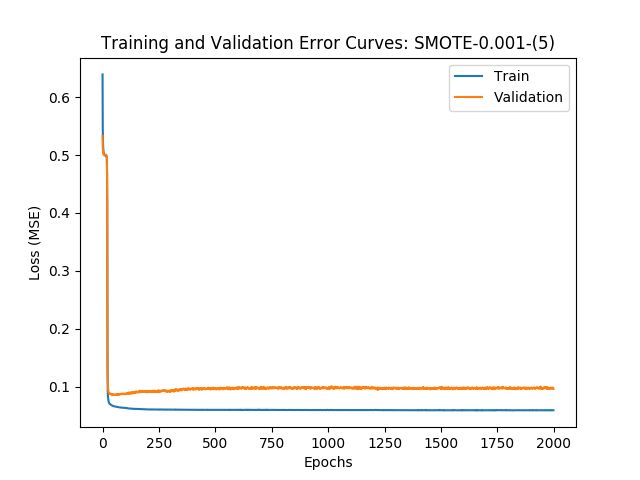

<IPython.core.display.Javascript object>


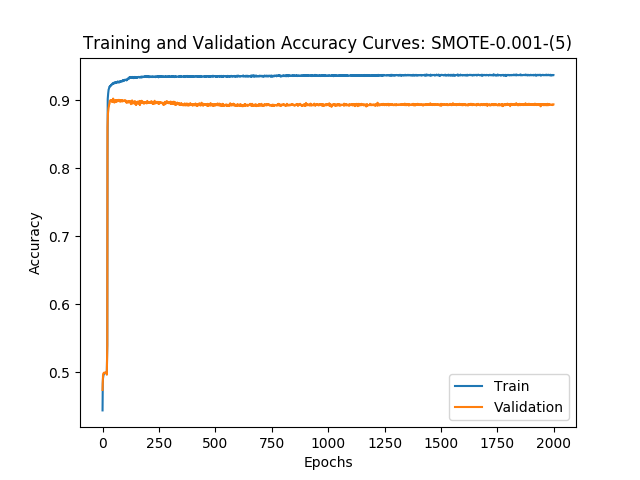

Matriz de confusão
[[1779  119]
 [   8   56]]

Train Loss:       0.0665
Validation Loss:  0.0853
Accuracy:         0.9353
MSE:              0.0647
AUROC:            0.9277


In [21]:
plot_training_error_curves(history, graficoName + "(5)")
plot_training_acc_curves(history, graficoName + "(5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (3, 5)

In [22]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2049 - acc: 0.7218 - val_loss: 0.1346 - val_acc: 0.8477
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0989 - acc: 0.8718 - val_loss: 0.1194 - val_acc: 0.8685
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0924 - acc: 0.8830 - val_loss: 0.1078 - val_acc: 0.8757
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0884 - acc: 0.8909 - val_loss: 0.1019 - val_acc: 0.8854
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0851 - acc: 0.8974 - val_loss: 0.0973 - val_acc: 0.8930
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0809 - acc: 0.9037 - val_loss: 0.0927 - val_acc: 0.8952
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0777 - acc: 0.9069 - val_loss: 0.0891 - val_acc: 0.8994
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9200 - val_loss: 0.0906 - val_acc: 0.8872
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9219 - val_loss: 0.0905 - val_acc: 0.8875
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9214 - val_loss: 0.0908 - val_acc: 0.8875
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9204 - val_loss: 0.0905 - val_acc: 0.8872
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9214 - val_loss: 0.0898 - val_acc: 0.8875
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9226 - val_loss: 0.0921 - val_acc: 0.8859
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9210 - val_loss: 0.0905 - val_acc: 0.8859
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9210 - val_loss: 0.0915 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0621 - acc: 0.9210 - val_loss: 0.0907 - val_acc: 0.8878
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0621 - acc: 0.9211 - val_loss: 0.0910 - val_acc: 0.8891
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0622 - acc: 0.9212 - val_loss: 0.0901 - val_acc: 0.8883
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0622 - acc: 0.9200 - val_loss: 0.0908 - val_acc: 0.8880
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0621 - acc: 0.9208 - val_loss: 0.0921 - val_acc: 0.8875
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9223 - val_loss: 0.0884 - val_acc: 0.8880
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0622 - acc: 0.9220 - val_loss: 0.0907 - val_acc: 0.8872
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9200 - val_loss: 0.0875 -

7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9223 - val_loss: 0.0896 - val_acc: 0.8888
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9210 - val_loss: 0.0895 - val_acc: 0.8888
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9208 - val_loss: 0.0897 - val_acc: 0.8901
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9218 - val_loss: 0.0901 - val_acc: 0.8891
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9216 - val_loss: 0.0904 - val_acc: 0.8872
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9208 - val_loss: 0.0903 - val_acc: 0.8875
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0621 - acc: 0.9219 - val_loss: 0.0895 - val_acc: 0.8872
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9214 - val_loss: 0.0902 -

7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9210 - val_loss: 0.0893 - val_acc: 0.8904
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9224 - val_loss: 0.0898 - val_acc: 0.8883
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9214 - val_loss: 0.0876 - val_acc: 0.8888
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9216 - val_loss: 0.0890 - val_acc: 0.8891
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0616 - acc: 0.9210 - val_loss: 0.0910 - val_acc: 0.8872
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9204 - val_loss: 0.0917 - val_acc: 0.8899
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0620 - acc: 0.9222 - val_loss: 0.0888 - val_acc: 0.8920
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9218 - val_loss: 0.0912 -

7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9207 - val_loss: 0.0887 - val_acc: 0.8949
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9214 - val_loss: 0.0892 - val_acc: 0.8896
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9218 - val_loss: 0.0888 - val_acc: 0.8899
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9208 - val_loss: 0.0901 - val_acc: 0.8875
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9207 - val_loss: 0.0902 - val_acc: 0.8880
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0616 - acc: 0.9214 - val_loss: 0.0897 - val_acc: 0.8878
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9208 - val_loss: 0.0879 - val_acc: 0.8907
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9210 - val_loss: 0.0890 -

7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9218 - val_loss: 0.0865 - val_acc: 0.8867
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0601 - acc: 0.9204 - val_loss: 0.0858 - val_acc: 0.8915
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9215 - val_loss: 0.0876 - val_acc: 0.8891
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0599 - acc: 0.9199 - val_loss: 0.0852 - val_acc: 0.8920
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0601 - acc: 0.9206 - val_loss: 0.0869 - val_acc: 0.8891
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0600 - acc: 0.9206 - val_loss: 0.0875 - val_acc: 0.8883
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9203 - val_loss: 0.0857 - val_acc: 0.8912
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0601 - acc: 0.9215 - val_loss: 0.0873 -

7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9218 - val_loss: 0.0888 - val_acc: 0.8872
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9227 - val_loss: 0.0864 - val_acc: 0.8936
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0591 - acc: 0.9233 - val_loss: 0.0889 - val_acc: 0.8912
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9215 - val_loss: 0.0866 - val_acc: 0.8912
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9233 - val_loss: 0.0870 - val_acc: 0.8930
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9228 - val_loss: 0.0866 - val_acc: 0.8949
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9232 - val_loss: 0.0855 - val_acc: 0.8941
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9222 - val_loss: 0.0886 -

7592/7592 [==============================] - 0s - loss: 0.0587 - acc: 0.9235 - val_loss: 0.0883 - val_acc: 0.8933
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0588 - acc: 0.9236 - val_loss: 0.0884 - val_acc: 0.8930
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9240 - val_loss: 0.0896 - val_acc: 0.8907
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9247 - val_loss: 0.0881 - val_acc: 0.8994
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9235 - val_loss: 0.0889 - val_acc: 0.8986
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0587 - acc: 0.9229 - val_loss: 0.0883 - val_acc: 0.8930
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0585 - acc: 0.9239 - val_loss: 0.0900 - val_acc: 0.8946
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9232 - val_loss: 0.0880 -

7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9240 - val_loss: 0.0902 - val_acc: 0.8991
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9247 - val_loss: 0.0883 - val_acc: 0.8978
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9237 - val_loss: 0.0894 - val_acc: 0.9015
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9247 - val_loss: 0.0903 - val_acc: 0.8954
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9241 - val_loss: 0.0873 - val_acc: 0.9041
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9240 - val_loss: 0.0900 - val_acc: 0.8952
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9236 - val_loss: 0.0894 - val_acc: 0.8973
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9235 - val_loss: 0.0900 -

7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9247 - val_loss: 0.0896 - val_acc: 0.8973
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9264 - val_loss: 0.0909 - val_acc: 0.9002
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9249 - val_loss: 0.0918 - val_acc: 0.8986
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9249 - val_loss: 0.0905 - val_acc: 0.9025
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9254 - val_loss: 0.0899 - val_acc: 0.9033
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9254 - val_loss: 0.0901 - val_acc: 0.9025
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9245 - val_loss: 0.0919 - val_acc: 0.8967
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9247 - val_loss: 0.0908 -

7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9257 - val_loss: 0.0914 - val_acc: 0.8999
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9262 - val_loss: 0.0898 - val_acc: 0.8999
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9244 - val_loss: 0.0941 - val_acc: 0.8999
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9266 - val_loss: 0.0914 - val_acc: 0.9028
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9261 - val_loss: 0.0918 - val_acc: 0.8944
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9260 - val_loss: 0.0915 - val_acc: 0.9004
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9244 - val_loss: 0.0934 - val_acc: 0.9025
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9265 - val_loss: 0.0890 -

7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9280 - val_loss: 0.0923 - val_acc: 0.9017
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9268 - val_loss: 0.0910 - val_acc: 0.9075
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9278 - val_loss: 0.0910 - val_acc: 0.9033
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9276 - val_loss: 0.0921 - val_acc: 0.9044
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9274 - val_loss: 0.0932 - val_acc: 0.9023
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9270 - val_loss: 0.0904 - val_acc: 0.9065
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9264 - val_loss: 0.0966 - val_acc: 0.9012
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9268 - val_loss: 0.0934 -

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9264 - val_loss: 0.0938 - val_acc: 0.9062
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9269 - val_loss: 0.0934 - val_acc: 0.9044
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9273 - val_loss: 0.0925 - val_acc: 0.9046
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9262 - val_loss: 0.0913 - val_acc: 0.9067
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9276 - val_loss: 0.0912 - val_acc: 0.9078
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9258 - val_loss: 0.0950 - val_acc: 0.9033
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9290 - val_loss: 0.0942 - val_acc: 0.9033
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9264 - val_loss: 0.0917 -

7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9268 - val_loss: 0.0971 - val_acc: 0.9054
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9270 - val_loss: 0.0963 - val_acc: 0.9052
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9269 - val_loss: 0.0935 - val_acc: 0.9060
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9268 - val_loss: 0.0960 - val_acc: 0.9081
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9268 - val_loss: 0.0930 - val_acc: 0.9057
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9276 - val_loss: 0.0938 - val_acc: 0.9062
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9282 - val_loss: 0.0937 - val_acc: 0.9041
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9277 - val_loss: 0.0964 -

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9278 - val_loss: 0.0952 - val_acc: 0.9060
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9293 - val_loss: 0.0936 - val_acc: 0.9041
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9286 - val_loss: 0.0979 - val_acc: 0.9015
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9289 - val_loss: 0.1003 - val_acc: 0.9031
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9269 - val_loss: 0.0930 - val_acc: 0.9070
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9273 - val_loss: 0.0947 - val_acc: 0.9078
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9283 - val_loss: 0.0938 - val_acc: 0.9070
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9287 - val_loss: 0.0948 -

7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9276 - val_loss: 0.0972 - val_acc: 0.9031
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9291 - val_loss: 0.0943 - val_acc: 0.9049
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9276 - val_loss: 0.0970 - val_acc: 0.9054
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9281 - val_loss: 0.1002 - val_acc: 0.9041
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9268 - val_loss: 0.0935 - val_acc: 0.9060
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9289 - val_loss: 0.0989 - val_acc: 0.9057
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9273 - val_loss: 0.0951 - val_acc: 0.9073
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9291 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9282 - val_loss: 0.0963 - val_acc: 0.9041
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9269 - val_loss: 0.0946 - val_acc: 0.9060
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9269 - val_loss: 0.0957 - val_acc: 0.9049
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9276 - val_loss: 0.0970 - val_acc: 0.9062
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9277 - val_loss: 0.0997 - val_acc: 0.9020
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9297 - val_loss: 0.0955 - val_acc: 0.9036
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9281 - val_loss: 0.0978 - val_acc: 0.9046
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9273 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9310 - val_loss: 0.0979 - val_acc: 0.9052
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9287 - val_loss: 0.0972 - val_acc: 0.9057
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9285 - val_loss: 0.0986 - val_acc: 0.9075
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9282 - val_loss: 0.0978 - val_acc: 0.9062
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9270 - val_loss: 0.0996 - val_acc: 0.9020
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9285 - val_loss: 0.0967 - val_acc: 0.9044
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9295 - val_loss: 0.0961 - val_acc: 0.9052
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9294 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9281 - val_loss: 0.0968 - val_acc: 0.9086
Epoch 1198/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9277 - val_loss: 0.0968 - val_acc: 0.9070
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9281 - val_loss: 0.0983 - val_acc: 0.9083
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9287 - val_loss: 0.0970 - val_acc: 0.9049
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9286 - val_loss: 0.0984 - val_acc: 0.9041
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9280 - val_loss: 0.1003 - val_acc: 0.9067
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9283 - val_loss: 0.1002 - val_acc: 0.9036
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9283 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9274 - val_loss: 0.1016 - val_acc: 0.9099
Epoch 1261/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9299 - val_loss: 0.0979 - val_acc: 0.9028
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9285 - val_loss: 0.1004 - val_acc: 0.9038
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9285 - val_loss: 0.0972 - val_acc: 0.9038
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9305 - val_loss: 0.1026 - val_acc: 0.9049
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9282 - val_loss: 0.1014 - val_acc: 0.9046
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9278 - val_loss: 0.0985 - val_acc: 0.9049
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9281 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9283 - val_loss: 0.0999 - val_acc: 0.9060
Epoch 1324/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9285 - val_loss: 0.0982 - val_acc: 0.9065
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9282 - val_loss: 0.0991 - val_acc: 0.9046
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9291 - val_loss: 0.0981 - val_acc: 0.9081
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9283 - val_loss: 0.1015 - val_acc: 0.9057
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9276 - val_loss: 0.0987 - val_acc: 0.9052
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9273 - val_loss: 0.1011 - val_acc: 0.9067
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9280 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9277 - val_loss: 0.1022 - val_acc: 0.9046
Epoch 1387/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9280 - val_loss: 0.1022 - val_acc: 0.9057
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9291 - val_loss: 0.1007 - val_acc: 0.9054
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9274 - val_loss: 0.1031 - val_acc: 0.9065
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9274 - val_loss: 0.0978 - val_acc: 0.9020
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9281 - val_loss: 0.1013 - val_acc: 0.9070
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9286 - val_loss: 0.0970 - val_acc: 0.9073
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9289 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9287 - val_loss: 0.1004 - val_acc: 0.9054
Epoch 1450/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9282 - val_loss: 0.1030 - val_acc: 0.9052
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9293 - val_loss: 0.1011 - val_acc: 0.9020
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9276 - val_loss: 0.1018 - val_acc: 0.9052
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9270 - val_loss: 0.1022 - val_acc: 0.9070
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9287 - val_loss: 0.1000 - val_acc: 0.9044
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9272 - val_loss: 0.1001 - val_acc: 0.9028
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9287 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9291 - val_loss: 0.1007 - val_acc: 0.9046
Epoch 1513/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9287 - val_loss: 0.1016 - val_acc: 0.9036
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9289 - val_loss: 0.1021 - val_acc: 0.9067
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9274 - val_loss: 0.1019 - val_acc: 0.9062
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9280 - val_loss: 0.1001 - val_acc: 0.9086
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9295 - val_loss: 0.1003 - val_acc: 0.9049
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9286 - val_loss: 0.1021 - val_acc: 0.9041
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9266 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9286 - val_loss: 0.1037 - val_acc: 0.9009
Epoch 1576/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9285 - val_loss: 0.1025 - val_acc: 0.9049
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9280 - val_loss: 0.1055 - val_acc: 0.9020
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9285 - val_loss: 0.1021 - val_acc: 0.9073
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9283 - val_loss: 0.1034 - val_acc: 0.9049
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9291 - val_loss: 0.1039 - val_acc: 0.9046
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9276 - val_loss: 0.1044 - val_acc: 0.9044
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9287 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9282 - val_loss: 0.1024 - val_acc: 0.9067
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9294 - val_loss: 0.1035 - val_acc: 0.9036
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9293 - val_loss: 0.1034 - val_acc: 0.9094
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9291 - val_loss: 0.1028 - val_acc: 0.9025
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9282 - val_loss: 0.1035 - val_acc: 0.9041
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9283 - val_loss: 0.1044 - val_acc: 0.9038
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9286 - val_loss: 0.1046 - val_acc: 0.9033
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9286 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9293 - val_loss: 0.1011 - val_acc: 0.9065
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9289 - val_loss: 0.1030 - val_acc: 0.9033
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9281 - val_loss: 0.1019 - val_acc: 0.9091
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9294 - val_loss: 0.1049 - val_acc: 0.9065
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9291 - val_loss: 0.1035 - val_acc: 0.9089
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9287 - val_loss: 0.1027 - val_acc: 0.9052
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9281 - val_loss: 0.1033 - val_acc: 0.9054
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9287 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9273 - val_loss: 0.1014 - val_acc: 0.9075
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9299 - val_loss: 0.1058 - val_acc: 0.9070
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9287 - val_loss: 0.1018 - val_acc: 0.9038
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9282 - val_loss: 0.1023 - val_acc: 0.9052
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9289 - val_loss: 0.1020 - val_acc: 0.9028
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9294 - val_loss: 0.1040 - val_acc: 0.9033
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9286 - val_loss: 0.1044 - val_acc: 0.9038
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9291 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9280 - val_loss: 0.1055 - val_acc: 0.9057
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9291 - val_loss: 0.1053 - val_acc: 0.9054
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9285 - val_loss: 0.1046 - val_acc: 0.9052
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9293 - val_loss: 0.1036 - val_acc: 0.9060
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9289 - val_loss: 0.1023 - val_acc: 0.9049
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9286 - val_loss: 0.1038 - val_acc: 0.9065
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9290 - val_loss: 0.1061 - val_acc: 0.9052
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9302 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9287 - val_loss: 0.1037 - val_acc: 0.9060
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9306 - val_loss: 0.1041 - val_acc: 0.9033
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9282 - val_loss: 0.1045 - val_acc: 0.9091
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9277 - val_loss: 0.1041 - val_acc: 0.9083
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9293 - val_loss: 0.1022 - val_acc: 0.9075
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9290 - val_loss: 0.1016 - val_acc: 0.9054
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9278 - val_loss: 0.1008 - val_acc: 0.9073
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9290 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9294 - val_loss: 0.1024 - val_acc: 0.9023
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9277 - val_loss: 0.1044 - val_acc: 0.9089
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9287 - val_loss: 0.1047 - val_acc: 0.9033
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9277 - val_loss: 0.1057 - val_acc: 0.9089
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9293 - val_loss: 0.1073 - val_acc: 0.9020
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9291 - val_loss: 0.1082 - val_acc: 0.9031
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9290 - val_loss: 0.1042 - val_acc: 0.9086
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9281 - val_loss: 0

In [23]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1568/1962 [======================>.......] - ETA: 0s[0.04409265602491682, 0.93679918456636557]


<IPython.core.display.Javascript object>


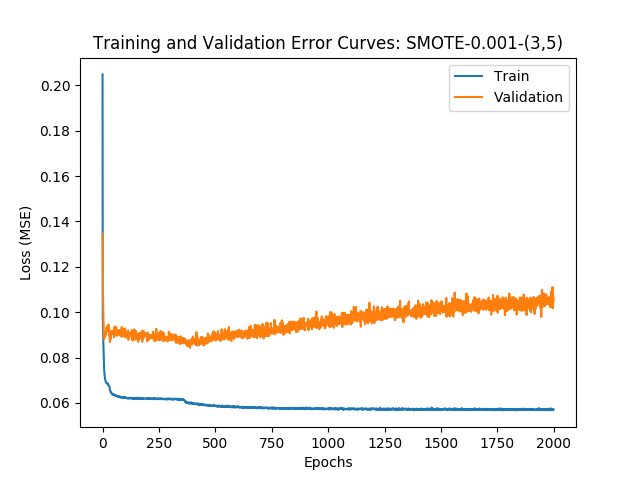

<IPython.core.display.Javascript object>


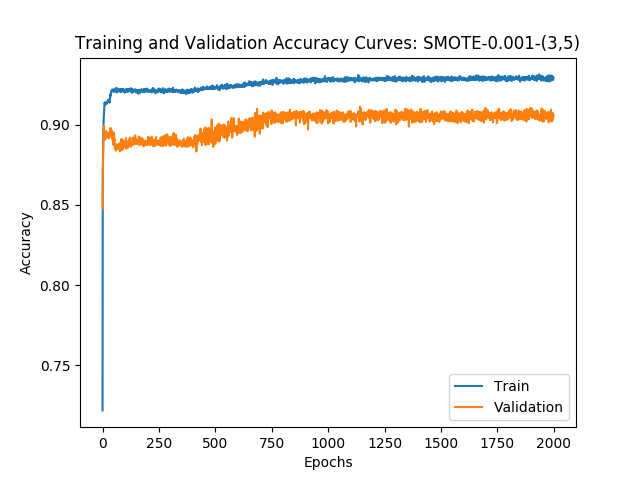

Matriz de confusão
[[1782  116]
 [   8   56]]

Train Loss:       0.0598
Validation Loss:  0.0843
Accuracy:         0.9368
MSE:              0.0632
AUROC:            0.9513


In [24]:
plot_training_error_curves(history, graficoName + "(3,5)")
plot_training_acc_curves(history,graficoName + "(3,5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [25]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_ac

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 760/2000
7592/7592 [==============================] - ETA: 0s - loss: 0.5005 - acc: 0.499 - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.5

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 -

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.5000 - acc: 0.5000 - val_loss: 0

In [26]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.032619775739041797, 0.96738022426095815]


<IPython.core.display.Javascript object>


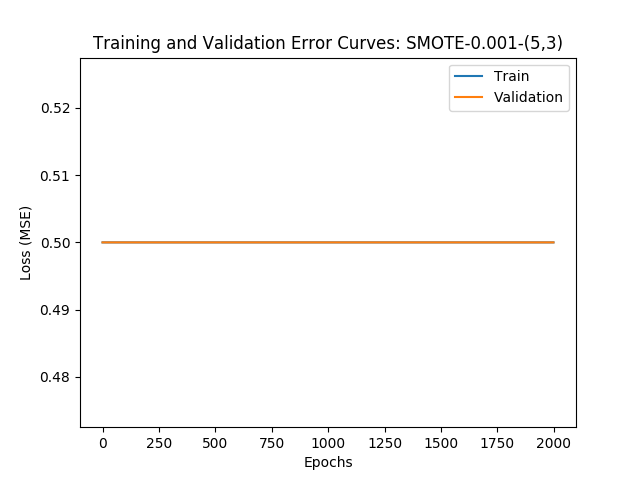

<IPython.core.display.Javascript object>


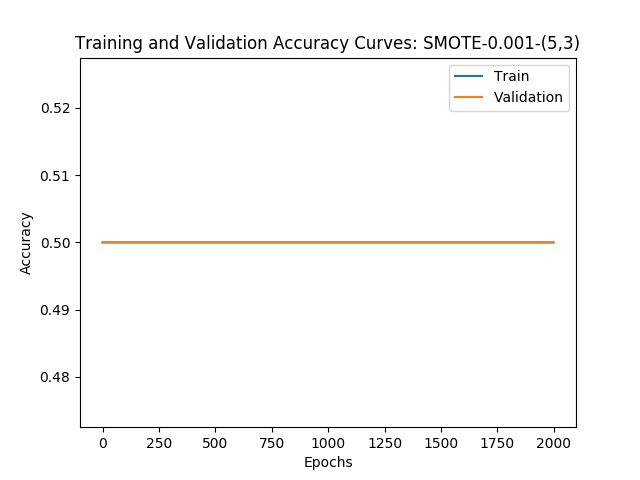

Matriz de confusão
[[1898    0]
 [  64    0]]

Train Loss:       0.5000
Validation Loss:  0.5000
Accuracy:         0.9674
MSE:              0.0326
AUROC:            0.5000


In [27]:
plot_training_error_curves(history, graficoName + "(5,3)")
plot_training_acc_curves(history, graficoName + "(5,3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [14]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.7101 - acc: 0.4763 - val_loss: 0.3978 - val_acc: 0.5050
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.3498 - acc: 0.6080 - val_loss: 0.2375 - val_acc: 0.7334
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.2259 - acc: 0.7408 - val_loss: 0.1758 - val_acc: 0.8119
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1536 - acc: 0.8177 - val_loss: 0.1620 - val_acc: 0.8195
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1184 - acc: 0.8634 - val_loss: 0.1480 - val_acc: 0.8380
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1062 - acc: 0.8854 - val_loss: 0.1343 - val_acc: 0.8554
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1003 - acc: 0.8933 - val_loss: 0.1260 - val_acc: 0.8733
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9073 - val_loss: 0.1107 - val_acc: 0.8880
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9062 - val_loss: 0.1094 - val_acc: 0.8899
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9070 - val_loss: 0.1090 - val_acc: 0.8891
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1093 - val_acc: 0.8896
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9073 - val_loss: 0.1124 - val_acc: 0.8872
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9067 - val_loss: 0.1127 - val_acc: 0.8878
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9074 - val_loss: 0.1115 - val_acc: 0.8883
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9078 - val_loss: 0.1093 -

7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9062 - val_loss: 0.1096 - val_acc: 0.8886
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9070 - val_loss: 0.1086 - val_acc: 0.8894
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9067 - val_loss: 0.1098 - val_acc: 0.8907
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1095 - val_acc: 0.8883
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9074 - val_loss: 0.1100 - val_acc: 0.8878
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1098 - val_acc: 0.8904
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9063 - val_loss: 0.1121 - val_acc: 0.8880
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1082 -

7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9082 - val_loss: 0.1092 - val_acc: 0.8883
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9077 - val_loss: 0.1100 - val_acc: 0.8880
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9077 - val_loss: 0.1091 - val_acc: 0.8904
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9067 - val_loss: 0.1105 - val_acc: 0.8883
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9073 - val_loss: 0.1105 - val_acc: 0.8878
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9074 - val_loss: 0.1081 - val_acc: 0.8915
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1106 - val_acc: 0.8883
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9079 - val_loss: 0.1090 -

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1083 - val_acc: 0.8901
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1079 - val_acc: 0.8907
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9073 - val_loss: 0.1111 - val_acc: 0.8888
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9062 - val_loss: 0.1096 - val_acc: 0.8886
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0.1088 - val_acc: 0.8888
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1084 - val_acc: 0.8912
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9065 - val_loss: 0.1132 - val_acc: 0.8862
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9069 - val_loss: 0.1077 -

7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9074 - val_loss: 0.1094 - val_acc: 0.8896
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9077 - val_loss: 0.1100 - val_acc: 0.8888
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1108 - val_acc: 0.8878
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9079 - val_loss: 0.1086 - val_acc: 0.8894
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9078 - val_loss: 0.1106 - val_acc: 0.8894
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9073 - val_loss: 0.1090 - val_acc: 0.8891
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1081 - val_acc: 0.8904
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1108 -

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1098 - val_acc: 0.8883
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9058 - val_loss: 0.1108 - val_acc: 0.8880
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9081 - val_loss: 0.1111 - val_acc: 0.8888
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1088 - val_acc: 0.8891
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9081 - val_loss: 0.1085 - val_acc: 0.8894
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1122 - val_acc: 0.8867
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1116 - val_acc: 0.8891
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9092 - val_loss: 0.1082 -

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1119 - val_acc: 0.8883
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9074 - val_loss: 0.1100 - val_acc: 0.8904
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1083 - val_acc: 0.8894
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9074 - val_loss: 0.1102 - val_acc: 0.8894
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0.1107 - val_acc: 0.8883
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9075 - val_loss: 0.1099 - val_acc: 0.8880
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9067 - val_loss: 0.1113 - val_acc: 0.8883
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9078 - val_loss: 0.1080 -

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9078 - val_loss: 0.1110 - val_acc: 0.8872
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1090 - val_acc: 0.8896
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9082 - val_loss: 0.1086 - val_acc: 0.8912
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1100 - val_acc: 0.8891
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9071 - val_loss: 0.1104 - val_acc: 0.8880
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1087 - val_acc: 0.8899
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9065 - val_loss: 0.1088 - val_acc: 0.8896
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9069 - val_loss: 0.1094 - val_acc: 0.8886
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1090 - val_acc: 0.8878
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1108 - val_acc: 0.8878
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1099 - val_acc: 0.8886
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1109 - val_acc: 0.8883
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9078 - val_loss: 0.1096 - val_acc: 0.8886
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1102 - val_acc: 0.8896
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9058 - val_loss: 0.1075 - val_acc: 0.8907
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1094 - val_acc: 0.8894
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9074 - val_loss: 0.1105 - val_acc: 0.8891
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9071 - val_loss: 0.1077 - val_acc: 0.8896
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9071 - val_loss: 0.1079 - val_acc: 0.8896
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9067 - val_loss: 0.1096 - val_acc: 0.8883
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1112 - val_acc: 0.8880
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9073 - val_loss: 0.1101 - val_acc: 0.8886
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9075 - val_loss: 0.1094 - val_acc: 0.8896
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9061 - val_loss: 0.1100 - val_acc: 0.8896
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9078 - val_loss: 0.1104 - val_acc: 0.8888
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9066 - val_loss: 0.1104 - val_acc: 0.8894
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9077 - val_loss: 0.1106 - val_acc: 0.8899
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0860 - acc: 0.9075 - val_loss: 0.1101 - val_acc: 0.8891
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1084 - val_acc: 0.8899
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1117 - val_acc: 0.8878
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1087 - val_acc: 0.8894
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0.1094 - val_acc: 0.8894
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1110 - val_acc: 0.8886
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9071 - val_loss: 0.1106 - val_acc: 0.8888
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1090 - val_acc: 0.8891
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0.1108 - val_acc: 0.8888
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9083 - val_loss: 0.1092 - val_acc: 0.8891
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9077 - val_loss: 0.1117 - val_acc: 0.8878
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9073 - val_loss: 0.1090 - val_acc: 0.8896
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9077 - val_loss: 0.1088 - val_acc: 0.8896
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0.1104 - val_acc: 0.8880
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9067 - val_loss: 0.1113 - val_acc: 0.8875
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9074 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9074 - val_loss: 0.1113 - val_acc: 0.8878
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9065 - val_loss: 0.1083 - val_acc: 0.8896
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9077 - val_loss: 0.1113 - val_acc: 0.8883
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9070 - val_loss: 0.1106 - val_acc: 0.8883
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9067 - val_loss: 0.1109 - val_acc: 0.8880
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9066 - val_loss: 0.1093 - val_acc: 0.8888
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1100 - val_acc: 0.8880
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9074 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9069 - val_loss: 0.1091 - val_acc: 0.8891
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9070 - val_loss: 0.1109 - val_acc: 0.8883
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9078 - val_loss: 0.1088 - val_acc: 0.8880
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9061 - val_loss: 0.1093 - val_acc: 0.8904
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1104 - val_acc: 0.8883
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9063 - val_loss: 0.1088 - val_acc: 0.8896
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9070 - val_loss: 0.1080 - val_acc: 0.8886
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0858 - acc: 0.9069 - val_loss: 0

In [15]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1536/1962 [======================>.......] - ETA: 0s[0.069336993642584263, 0.92456676860346587]


<IPython.core.display.Javascript object>


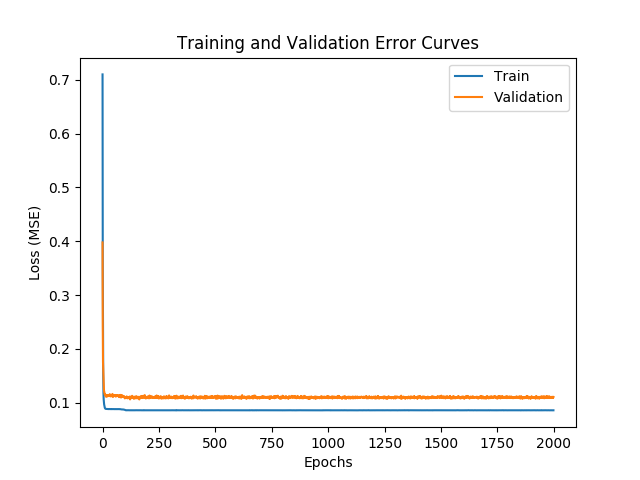

<IPython.core.display.Javascript object>


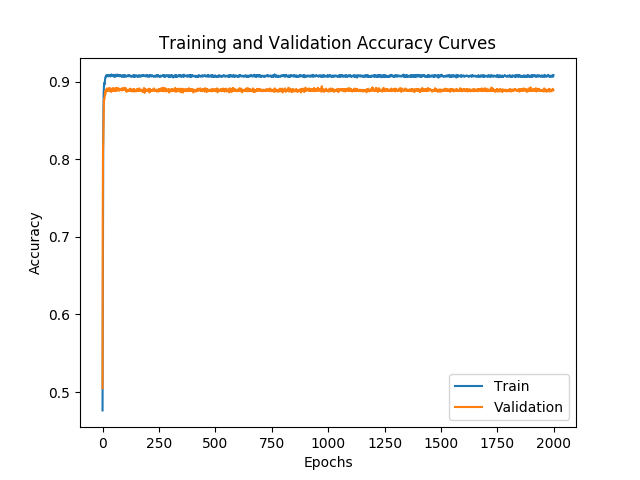

In [16]:
plot_training_error_curves(history, graficoName + "(2)")
plot_training_acc_curves(history, graficoName + "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(4)")
plot_training_acc_curves(history, graficoName + "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))